In [ ]:
import pandas as pd
import numpy as np
import re
import requests
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from datasets import load_dataset
import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!sudo apt-get update
!sudo apt-get install openjdk-17-jdk -y

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,604 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,844 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [3,140 kB]
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:13 https://ppa.launchpadcontent.net/ubuntugis/p

In [ ]:
!sudo update-alternatives --install /usr/bin/java java /usr/lib/jvm/java-17-openjdk-amd64/bin/java 1
!sudo update-alternatives --set java /usr/lib/jvm/java-17-openjdk-amd64/bin/java

update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/java to provide /usr/bin/java (java) in auto mode
update-alternatives: using /usr/lib/jvm/java-17-openjdk-amd64/bin/java to provide /usr/bin/java (java) in manual mode


In [ ]:
!pip install language_tool_python
!pip install datasets
!pip install nltk
!pip install beautifulsoup4
!pip install lxml[html_clean]

In [ ]:
from nltk.corpus import stopwords
import language_tool_python

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    if pd.isna(text) or text == "":
        return ""
    words = nltk.word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return " ".join(filtered_words)

dataset = load_dataset('sergioburdisso/news_media_reliability')
reliability_df = pd.DataFrame(dataset['train'])
print(f"Columns: {reliability_df.columns.tolist()}")
# COLUMNS OF THIS DATASET:
#domain: domain name,
#reliability_label: the reliability label ( 1: generally reliable; 0: mixed; -1: generally unreliable)
#newsguard_score: human-provided reliability score (only available for a small subset). Value: integer number between 0 and 100.
source_reliability = dict(zip(reliability_df['domain'], reliability_df['reliability_label']))


fake_news_dataset = load_dataset("ErfanMoosaviMonazzah/fake-news-detection-dataset-English")
news_df = pd.DataFrame(fake_news_dataset['train'])

print("Dataset loaded successfully!")
print(f"Columns: {news_df.columns.tolist()}")
print(f"Label distribution: {news_df['label'].value_counts().to_dict()}")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

data.csv:   0%|          | 0.00/104k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5332 [00:00<?, ? examples/s]

Columns: ['domain', 'reliability_label', 'newsguard_score']


README.md:   0%|          | 0.00/487 [00:00<?, ?B/s]

train.tsv:   0%|          | 0.00/78.4M [00:00<?, ?B/s]

validation.tsv:   0%|          | 0.00/15.5M [00:00<?, ?B/s]

test.tsv:   0%|          | 0.00/22.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/30000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/8267 [00:00<?, ? examples/s]

Dataset loaded successfully!
Columns: ['Unnamed: 0', 'title', 'text', 'subject', 'date', 'label']
Label distribution: {0: 15478, 1: 14522}


In [ ]:
# language tool for grammar checking
language_tool = language_tool_python.LanguageTool('en-US')

news_df['text'] = news_df['text'].apply(remove_stopwords)
reliability_df['text'] = reliability_df['domain'].apply(remove_stopwords)

INFO:language_tool_python.download_lt:Unzipping /tmp/tmp1s6a82no.zip to /root/.cache/language_tool_python.
INFO:language_tool_python.download_lt:Downloaded https://internal1.languagetool.org/snapshots/LanguageTool-latest-snapshot.zip to /root/.cache/language_tool_python.


In [ ]:
def extract_domain(url):
    if pd.isna(url):
        return None
    try:
        match = re.search(r'https?://(?:www\.)?([^/]+)', url)
        if match:
            return match.group(1)
        return None
    except:
        return None

def calculate_grammar_score(text):
    if pd.isna(text) or text.strip() == "":
        text = "This article may lack content or failed to load properly."

    try:
        sample_text = str(text)[:5000]
        errors = language_tool.check(sample_text)
        word_count = len(sample_text.split())

        if word_count == 0:
            return 60

        error_rate = (len(errors) / word_count) * 100
        base_score = 100 - error_rate

        penalty = 0.8 if error_rate > 10 else 1.0
        score = max(20, base_score * penalty)
        return score
    except:
        return 60
def excessive_punctuation_score(text):
    if pd.isna(text) or text.strip() == "":
        text = "This article may lack content or failed to load properly."

    text = str(text)
    total_chars = len(text)

    if total_chars == 0:
        return 60

    punctuation_count = sum(1 for char in text if char in '.,!?;:\'"-()[]{}')
    punctuation_ratio = punctuation_count / total_chars

    raw_score = 100 - (punctuation_ratio * 500)

    if punctuation_ratio > 0.1:
        score = raw_score * 0.85
    else:
        score = raw_score

    return max(20, min(score, 100))


def get_source_reliability_score(domain):
    if domain is None:
        return 50

    if domain in source_reliability:
        rel_label = source_reliability[domain]
        if rel_label == 1:
            return 90
        elif rel_label == 0:
            return 50
        else:
            return 10
    else:
        return 50

def fetch_article_content(url):
    try:
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()

        soup = BeautifulSoup(response.text, 'html.parser')
        title = soup.title.text.strip() if soup.title else ""

        for script in soup(["script", "style"]):
            script.decompose()

        paragraphs = soup.find_all('p')
        text = ' '.join([p.text.strip() for p in paragraphs])

        return {
            'title': title,
            'text': text
        }
    except Exception as e:
        print(f"Error fetching article: {e}")
        return {'title': "", 'text': ""}

In [ ]:
# news_df = news_df.dropna(subset=['text'])

# X = news_df['text'].values
# y = news_df['label'].values

# print("Label distribution:")
# print(pd.Series(y).value_counts())

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)




# vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
# X_train_vec = vectorizer.fit_transform(X_train)
# X_test_vec = vectorizer.transform(X_test)



# content_classifier = RandomForestClassifier(
#     n_estimators=100,
#     max_depth=20,
#     min_samples_split=10,
#     min_samples_leaf=5,
#     random_state=42
# )



# content_classifier.fit(X_train_vec, y_train)

# y_pred = content_classifier.predict(X_test_vec)
# print("Content Classifier Performance:")
# print(classification_report(y_test, y_pred))
# print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

news_df = news_df.dropna(subset=['text'])

X = news_df['text'].values
y = news_df['label'].values

print("Label distribution:")
print(pd.Series(y).value_counts())

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = SentenceTransformer('all-MiniLM-L6-v2')

X_train_vec = model.encode(X_train, show_progress_bar=True)
X_test_vec = model.encode(X_test, show_progress_bar=True)

# Use Logistic Regression for simplicity and performance
#content_classifier = LogisticRegression(max_iter=1000, random_state=42)
# Alternatively, use XGBoost for higher performance:
content_classifier = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

content_classifier.fit(X_train_vec, y_train)

y_pred = content_classifier.predict(X_test_vec)
print("Content Classifier Performance:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")


Label distribution:
0    15478
1    14522
Name: count, dtype: int64


Batches:   0%|          | 0/750 [00:00<?, ?it/s]

Batches:   0%|          | 0/188 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:55:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Content Classifier Performance:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      3096
           1       0.95      0.94      0.95      2904

    accuracy                           0.95      6000
   macro avg       0.95      0.95      0.95      6000
weighted avg       0.95      0.95      0.95      6000

Accuracy: 0.9472


In [ ]:
def analyze_news_article(url):
    try:
        domain = extract_domain(url)

        article_content = fetch_article_content(url)
        text = article_content['text']
        title = article_content['title']

        grammar_score = calculate_grammar_score(text)
        punctuation_score = excessive_punctuation_score(text)
        source_score = get_source_reliability_score(domain)

        if len(text) > 0:
            text_vec = vectorizer.transform([text])
            content_pred_proba = content_classifier.predict_proba(text_vec)[0]
            real_class_idx = list(content_classifier.classes_).index(1) if 1 in content_classifier.classes_ else 0
            content_score = content_pred_proba[real_class_idx] * 100
        else:
            content_score = 50

        overall_score = (
            source_score * 0.45 +
            content_score * 0.2 +
            grammar_score * 0.2 +
            punctuation_score * 0.15
        )

        results = {
            'url': url,
            'domain': domain,
            'title': title,
            'source_reliability_score': source_score,
            'content_credibility_score': content_score,
            'grammar_score': grammar_score,
            'punctuation_score': punctuation_score,
            'overall_credibility_score': overall_score,
            'credibility_rating': get_credibility_rating(overall_score)
        }

        return results

    except Exception as e:
        print(f"Error analyzing article: {e}")
        return None

def get_credibility_rating(score):
    if score >= 80:
        return "Highly Credible"
    elif score >= 65:
        return "Mostly Credible"
    elif score >= 50:
        return "Somewhat Credible"
    elif score >= 35:
        return "Questionable"
    else:
        return "Low Credibility"

def visualize_credibility_analysis(results):
    if results is None:
        print("No results to visualize")
        return

    scores = {
        'Source Reliability': results['source_reliability_score'],
        'Content Analysis': results['content_credibility_score'],
        'Grammar Quality': results['grammar_score'],
        'Punctuation': results['punctuation_score'],
        'Overall': results['overall_credibility_score']
    }

    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(scores.keys()), y=list(scores.values()))
    plt.title(f"News Credibility Analysis: {results['credibility_rating']}")
    plt.ylim(0, 100)
    plt.axhline(y=50, color='red', linestyle='--', alpha=0.5)
    plt.ylabel('Score (0-100)')
    plt.tight_layout()
    plt.show()

    print(f"\nArticle: {results['title']}")
    print(f"Source: {results['domain']}")
    print(f"Overall Credibility: {results['overall_credibility_score']:.1f}/100 ({results['credibility_rating']})")
    print("\nComponent Scores:")
    for component, score in scores.items():
        if component != 'Overall':
            print(f"- {component}: {score:.1f}/100")


Analyzing: https://www.reuters.com/world/us/trump-pick-jd-vance-gop-vice-presidential-nominee-2024-07-15/
Error fetching article: 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/world/us/trump-pick-jd-vance-gop-vice-presidential-nominee-2024-07-15/


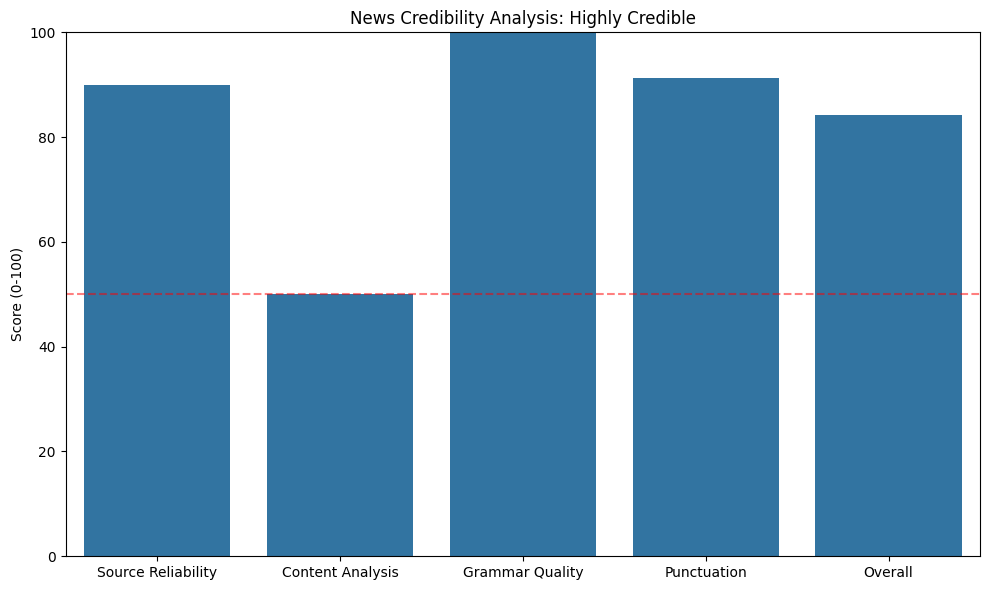


Article: 
Source: reuters.com
Overall Credibility: 84.2/100 (Highly Credible)

Component Scores:
- Source Reliability: 90.0/100
- Content Analysis: 50.0/100
- Grammar Quality: 100.0/100
- Punctuation: 91.2/100

Analyzing: https://www.bbc.com/news/world-us-canada-66913892
Error fetching article: 404 Client Error: Not Found for url: https://www.bbc.com/news/world-us-canada-66913892


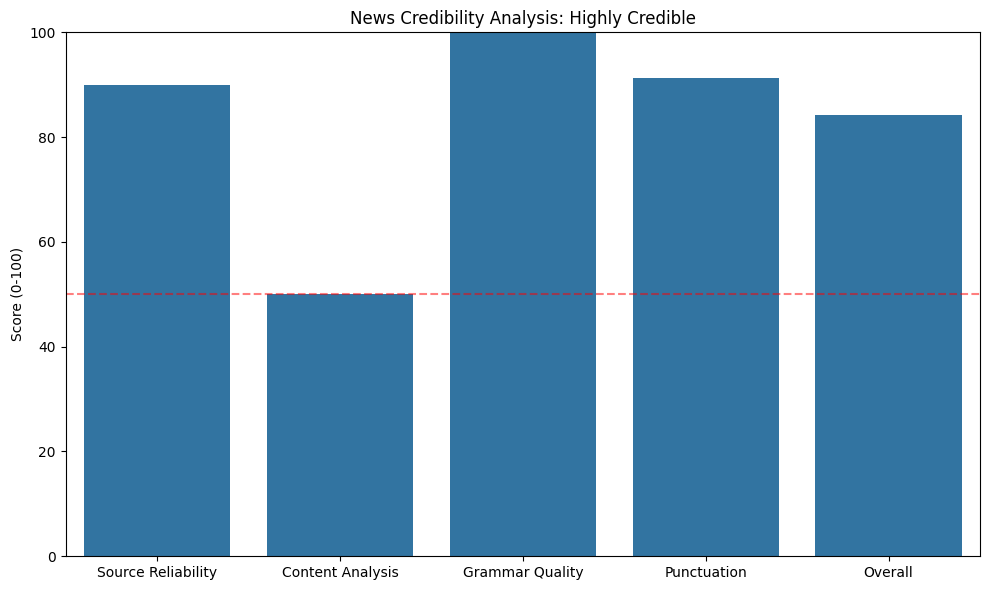


Article: 
Source: bbc.com
Overall Credibility: 84.2/100 (Highly Credible)

Component Scores:
- Source Reliability: 90.0/100
- Content Analysis: 50.0/100
- Grammar Quality: 100.0/100
- Punctuation: 91.2/100

Analyzing: https://www.theonion.com/report-nobody-cares-about-thing-you-re-about-to-post-1850294785
Error fetching article: 404 Client Error: Not Found for url: https://theonion.com/report-nobody-cares-about-thing-you-re-about-to-post-1850294785


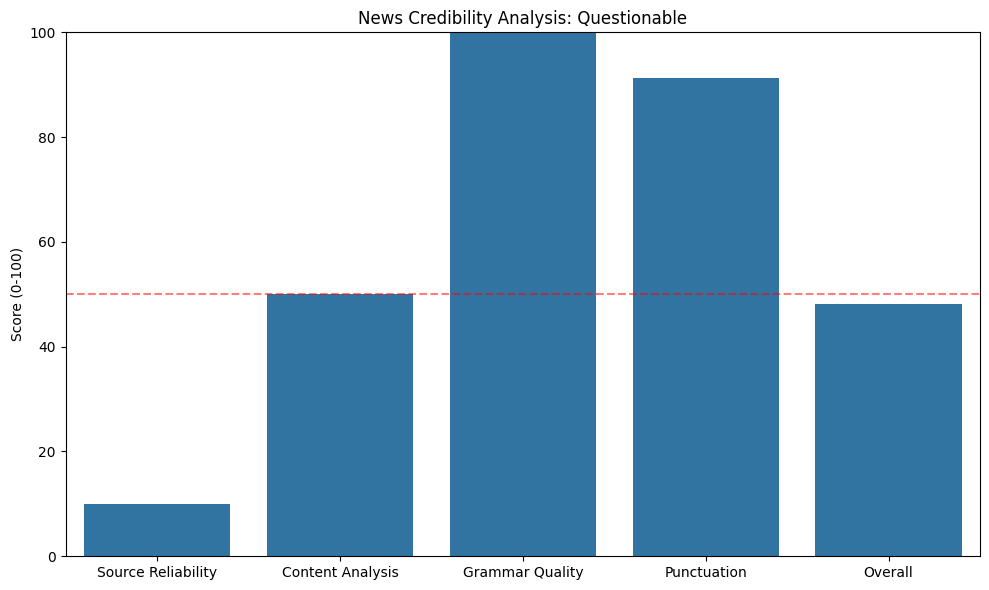


Article: 
Source: theonion.com
Overall Credibility: 48.2/100 (Questionable)

Component Scores:
- Source Reliability: 10.0/100
- Content Analysis: 50.0/100
- Grammar Quality: 100.0/100
- Punctuation: 91.2/100


In [ ]:
test_urls = [
    "https://www.reuters.com/world/us/trump-pick-jd-vance-gop-vice-presidential-nominee-2024-07-15/",
    "https://www.bbc.com/news/world-us-canada-66913892",
    "https://www.theonion.com/report-nobody-cares-about-thing-you-re-about-to-post-1850294785"
]

for url in test_urls:
    print("\n" + "="*50)
    print(f"Analyzing: {url}")
    results = analyze_news_article(url)
    visualize_credibility_analysis(results)

In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system ==

In [ ]:
# import torch
# print(torch.cuda.is_available())
# print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch
from nltk.corpus import stopwords
import nltk
from datasets import load_dataset
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
import numpy as np
import torch.optim as optim

nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [4]:
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    if pd.isna(text) or text == "":
        return ""
    words = nltk.word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return " ".join(filtered_words)

source_reliability_dataset = load_dataset('sergioburdisso/news_media_reliability')
reliability_df = pd.DataFrame(source_reliability_dataset['train'])
print(f"Columns: {reliability_df.columns.tolist()}")
# COLUMNS OF THIS DATASET:
#domain: domain name,
#reliability_label: the reliability label ( 1: generally reliable; 0: mixed; -1: generally unreliable)
#newsguard_score: human-provided reliability score (only available for a small subset). Value: integer number between 0 and 100.
source_reliability = dict(zip(reliability_df['domain'], reliability_df['reliability_label']))

df = reliability_df.dropna(subset=['domain', 'newsguard_score'])
df['score'] = df['newsguard_score'] / 100.0
df['domain'] = df['domain'].apply(remove_stopwords)

vectorizer_source_reliability = TfidfVectorizer(analyzer='char', ngram_range=(2, 4), max_features=1000)

X_source_reliability = vectorizer_source_reliability.fit_transform(df['domain']).toarray()
y_source_reliability = df['score'].values

X_train_source_reliability, X_val_source_reliability, y_train_source_reliability, y_val_source_reliability = train_test_split(X_source_reliability, y_source_reliability, test_size=0.2, random_state=42)

X_train_tensor_source_reliability = torch.tensor(X_train_source_reliability, dtype=torch.float32)
y_train_tensor_source_reliability = torch.tensor(y_train_source_reliability, dtype=torch.float32).unsqueeze(1)
X_val_tensor_source_reliability = torch.tensor(X_val_source_reliability, dtype=torch.float32)
y_val_tensor_source_reliability = torch.tensor(y_val_source_reliability, dtype=torch.float32).unsqueeze(1)




fake_news_dataset = load_dataset("ErfanMoosaviMonazzah/fake-news-detection-dataset-English")
news_credibility_df = pd.DataFrame(fake_news_dataset['train'])
news_credibility_df = news_credibility_df.dropna(subset=['text', 'label'])

print(f"Label distribution: {news_credibility_df['label'].value_counts()}")
print(f"Label unique values: {news_credibility_df['label'].unique()}")

labels = news_credibility_df['label'].values
if len(np.unique(labels)) == 2:
    news_credibility_df['label'] = news_credibility_df['label'].astype(float)
else:
    min_label = labels.min()
    max_label = labels.max()
    news_credibility_df['label'] = (news_credibility_df['label'] - min_label) / (max_label - min_label)

embedder = SentenceTransformer('all-MiniLM-L6-v2')
sample_size = min(20000, len(news_credibility_df))
sampled_df = news_credibility_df.sample(sample_size, random_state=42)
print(f"Creating embeddings for {sample_size} samples...")
embeddings = embedder.encode(sampled_df['text'].tolist(), batch_size=32, show_progress_bar=True)

X = np.array(embeddings)
y = sampled_df['label'].values.astype(np.float32)

print(f"Target values distribution: {np.histogram(y, bins=5)}")

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

data.csv:   0%|          | 0.00/104k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5332 [00:00<?, ? examples/s]

Columns: ['domain', 'reliability_label', 'newsguard_score']


<ipython-input-4-8c2995bfaa15>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = df['newsguard_score'] / 100.0
<ipython-input-4-8c2995bfaa15>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['domain'] = df['domain'].apply(remove_stopwords)


README.md:   0%|          | 0.00/487 [00:00<?, ?B/s]

train.tsv:   0%|          | 0.00/78.4M [00:00<?, ?B/s]

validation.tsv:   0%|          | 0.00/15.5M [00:00<?, ?B/s]

test.tsv:   0%|          | 0.00/22.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/30000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/8267 [00:00<?, ? examples/s]

Label distribution: label
0    15478
1    14522
Name: count, dtype: int64
Label unique values: [1 0]


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Creating embeddings for 20000 samples...


Batches:   0%|          | 0/625 [00:00<?, ?it/s]

Target values distribution: (array([10386,     0,     0,     0,  9614]), array([0. , 0.2, 0.4, 0.6, 0.8, 1. ], dtype=float32))


In [5]:
class DomainReliabilityClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

model_source_reliability = DomainReliabilityClassifier(input_dim=X_source_reliability.shape[1])


class NewsCredibilityClassifier(nn.Module):
    def __init__(self, input_dim=384, hidden_dim=128):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.bn2 = nn.BatchNorm1d(hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, 1)
        self.dropout = nn.Dropout(0.3)
        self.leaky_relu = nn.LeakyReLU(0.1)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)

        x = self.fc3(x)
        x = torch.sigmoid(x)
        return x

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
print(f"Using device: {device}")

model = NewsCredibilityClassifier().to(device)

Using device: cpu


In [6]:
#loss_fn = nn.CrossEntropyLoss()
loss_fn_source_reliability = nn.MSELoss()
optimizer_source_reliability = torch.optim.Adam(model_source_reliability.parameters(), lr=1e-3)
train_loader_source_reliability = DataLoader(TensorDataset(X_train_tensor_source_reliability, y_train_tensor_source_reliability), batch_size=16, shuffle=True)
val_loader_source_reliability = DataLoader(TensorDataset(X_val_tensor_source_reliability, y_val_tensor_source_reliability), batch_size=32)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_source_reliability = model_source_reliability.to(device)

for epoch in range(10):
    model_source_reliability.train()
    for xb_source_reliability, yb_source_reliability in train_loader_source_reliability:
        xb_source_reliability, yb_source_reliability = xb_source_reliability.to(device), yb_source_reliability.to(device)
        optimizer_source_reliability.zero_grad()
        preds_source_reliability = model_source_reliability(xb_source_reliability)
        loss_source_reliability = loss_fn_source_reliability(preds_source_reliability, yb_source_reliability)
        loss_source_reliability.backward()
        optimizer_source_reliability.step()

    model_source_reliability.eval()
    val_acc_source_reliability = 0
    with torch.no_grad():
        mse_source_reliability, total_source_reliability = 0, 0
        for xb_source_reliability, yb_source_reliability in val_loader_source_reliability:
            xb_source_reliability, yb_source_reliability = xb_source_reliability.to(device), yb_source_reliability.to(device)
            preds_source_reliability = model_source_reliability(xb_source_reliability)
            mse_source_reliability += ((preds_source_reliability - yb_source_reliability)**2).sum().item()
            total_source_reliability += yb_source_reliability.size(0)
        val_mse_source_reliability = mse_source_reliability / total_source_reliability
    print(f"Epoch {epoch+1}, Val MSE: {val_mse_source_reliability:.4f}")





loss_fn = nn.MSELoss()

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=16, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=32)

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

num_epochs = 20
best_val_loss = float('inf')
early_stopping_patience = 5
counter = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    all_train_preds = []

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        all_train_preds.extend(outputs.detach().cpu().numpy())

    avg_train_loss = train_loss / len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    all_val_preds = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, targets)

            val_loss += loss.item() * inputs.size(0)
            all_val_preds.extend(outputs.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader.dataset)

    scheduler.step(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f}")
    print(f"  Prediction distribution: {np.histogram(all_val_preds, bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])}")

Epoch 1, Val MSE: 0.1425
Epoch 2, Val MSE: 0.1382
Epoch 3, Val MSE: 0.1338
Epoch 4, Val MSE: 0.1289
Epoch 5, Val MSE: 0.1237
Epoch 6, Val MSE: 0.1183
Epoch 7, Val MSE: 0.1130
Epoch 8, Val MSE: 0.1080
Epoch 9, Val MSE: 0.1038
Epoch 10, Val MSE: 0.1007
Epoch 1/20
  Train Loss: 0.0846
  Val Loss: 0.0535
  Prediction distribution: (array([1654,  203,  193,  199, 1751]), array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]))
Epoch 2/20
  Train Loss: 0.0626
  Val Loss: 0.0452
  Prediction distribution: (array([1809,  175,  147,  193, 1676]), array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]))
Epoch 3/20
  Train Loss: 0.0545
  Val Loss: 0.0445
  Prediction distribution: (array([1794,  155,  133,  146, 1772]), array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]))
Epoch 4/20
  Train Loss: 0.0512
  Val Loss: 0.0417
  Prediction distribution: (array([1844,  164,  114,  176, 1702]), array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]))
Epoch 5/20
  Train Loss: 0.0507
  Val Loss: 0.0426
  Prediction distribution: (array([1784,  146,  115,  161, 1794]), arr

In [7]:
import re
from urllib.parse import urlparse

def extract_domains_dict(text):
    url_pattern = re.compile(
        r'(https?://[^\s]+|(?:[a-zA-Z0-9-]+\.)+[a-zA-Z]{2,})'
    )
    matches = url_pattern.findall(text)

    domains = set()
    for match in matches:
        if match.startswith('http'):
            parsed = urlparse(match)
            domain = parsed.netloc
        else:
            domain = match
        domain = domain.lower().lstrip("www.")
        domains.add(domain)

    return {
        "text": text,
        "domains": list(domains)
    }


def predict_source_reliability(domain_name_source_reliability: str):
    model_source_reliability.eval()
    vec_source_reliability = vectorizer_source_reliability.transform([domain_name_source_reliability]).toarray()
    tensor_source_reliability = torch.tensor(vec_source_reliability, dtype=torch.float32).to(device)
    with torch.no_grad():
        score_source_reliability = model_source_reliability(tensor_source_reliability).item()  # model outputs a single float in [0,1]
        return round(score_source_reliability, 3)
test1 = "Visit https://www.bbc.co.uk/news or just check bbc.co.uk and cnn.com"
print(extract_domains_dict(test1)["domains"][1])
print(predict_source_reliability(extract_domains_dict(test1)["domains"][1]))


def predict_news_credibility(text):
    model.eval()
    vec = embedder.encode([text])
    tensor = torch.tensor(vec, dtype=torch.float32).to(device)

    with torch.no_grad():
        raw_score = model(tensor).item()
        print(f"Raw prediction: {raw_score}")
        return round(raw_score, 3)

test_texts = [
    "Breaking: Scientists discover miracle cure for all diseases",
    "Research study published in Nature shows promising results for new cancer treatment",
    "President announces major policy shift based on expert recommendations",
    "Anonymous source claims government hiding aliens in secret facility",
    "Local community comes together to rebuild after devastating storm"
]

print("\nTesting model predictions:")
for text in test_texts:
    score = predict_news_credibility(text)
    print(f"Text: {text[:50]}...")
    print(f"Credibility score: {score}")
    print("---")

cnn.com
0.67

Testing model predictions:
Raw prediction: 0.0071996720507740974
Text: Breaking: Scientists discover miracle cure for all...
Credibility score: 0.007
---
Raw prediction: 0.5306042432785034
Text: Research study published in Nature shows promising...
Credibility score: 0.531
---
Raw prediction: 0.9972660541534424
Text: President announces major policy shift based on ex...
Credibility score: 0.997
---
Raw prediction: 0.16033786535263062
Text: Anonymous source claims government hiding aliens i...
Credibility score: 0.16
---
Raw prediction: 0.957263171672821
Text: Local community comes together to rebuild after de...
Credibility score: 0.957
---
